In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../../latent_analysis/'))
sys.path.append(os.path.abspath('../../dPCA/python/'))
import LTransform as LT
from get_utils import get_hidden, get_dir
from pathlib import Path
import numpy as np
import torch as th
import plot as plot
import matplotlib.pyplot as plt

In [2]:
# Load hidden
folder_name = 'Sim_all_inv'
model_num = 0
model_name = "model{:02d}".format(model_num)

ff_coef = [0,8,0,8,-8]
phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8,-8]}

data = get_hidden(folder_name,model_name,phase,ff_coef,demean=True)

In [3]:
# Apply SVD
n_muscle = 6
n_latent = 6
n_pot = 6

# Apply PCA
Data_prep =  {'x_ld':[],'x':[]}
for i in range(len(data)):
    X = data[i]
    if i==0:
        T = LT.Transform(num_latent=n_latent)
        T.fit(X,method='PCA')        
        
    x_ld = T.transform(X,ensure_orthogonality=True)

    Data_prep['x_ld'].append(x_ld)
    Data_prep['x'].append(X)

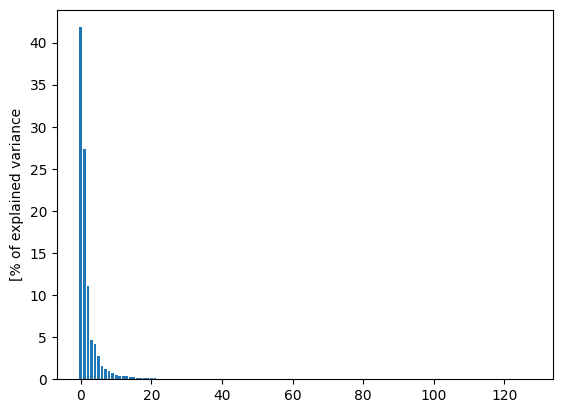

In [4]:
import seaborn as sns

plt.figure()
plt.bar(np.arange(len(T.variance_explained)), 100*T.variance_explained)
plt.ylabel('[% of explained variance')
plt.show()

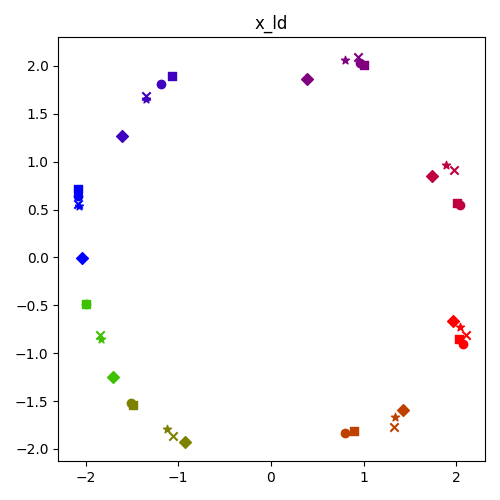

In [5]:
%matplotlib widget
#%matplotlib qt
# ['x', 'o', '*', 's']
latent = [0,1,2]
dim=2
which_times = np.arange(10)
which_times =[18]
plot_scatter=1

if dim==2:
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax = [ax]
else:
    fig,ax = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection':'3d'})
    ax = [ax]

plot.plot_traj(ax[0],Data_prep['x_ld'],which_times=which_times,plot_scatter=plot_scatter,dim=dim,which_latent=latent)
ax[0].set_title('x_ld')


plt.tight_layout()
plt.show()

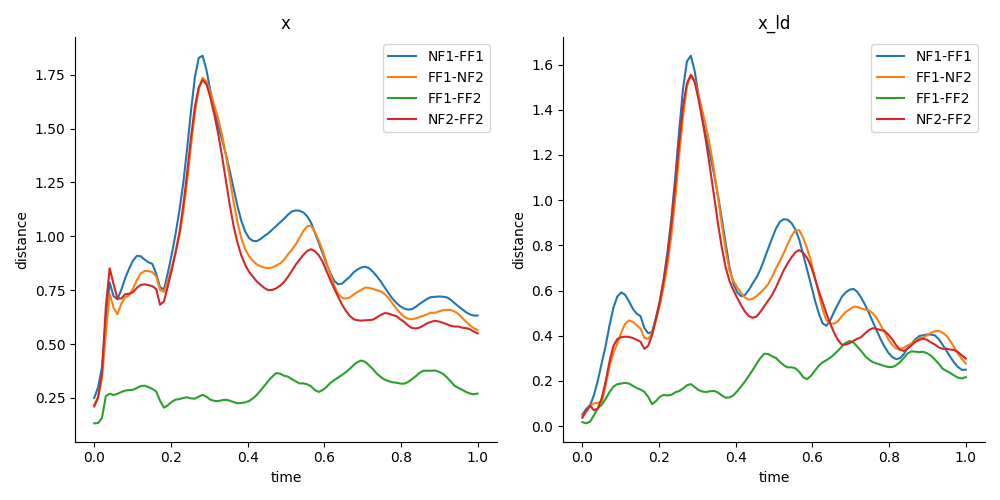

In [49]:
# 0-NF1, 1-FF1, 2-NF2, 3-FF2
# 0-(0,1) NF1-FF1 
# 1-(0,2) NF1-NF2 X
# 2-(0,3) NF1-FF2 X
# 3-(1,2) FF1-NF2 X
# 4-(1,3) FF1-FF2 X
# 5-(2,3) NF2-FF2

fig,ax = plt.subplots(1,2,figsize=(10,5))
from scipy.spatial.distance import pdist, squareform

color_list = ['blue','orange','red','green','cyan','purple']
style = ['-','-','-','-','-','-']
label = ['NF1-FF1','NF1-NF2','NF1-FF2','FF1-NF2','FF1-FF2','NF2-FF2']
label = ['NF1-FF1','NF1-NF2','NF1-FF2','NF1-FF3','FF1-NF2','FF1-FF2','FF1-FF3','NF2-FF2','NF2-FF3','FF2-FF3']


for k,s in enumerate(['x','x_ld']):
    D = np.stack(Data_prep[s])
    dist = np.zeros((8,100,10))
    for i in range(8):
        for j in range(100):
            dist[i,j,:] = pdist(D[:,i,j,:])

    dist = np.mean(dist,axis=0)

    x = np.linspace(0,1,dist.shape[0])

    for i,d in enumerate([0,4,5,7]): # [0,5]  [1,4]
        ax[k].plot(x,dist[:,d],label=label[d]) # ,color=color_list[d],linestyle=style[d]
    ax[k].legend()
    ax[k].set_xlabel('time')
    ax[k].set_ylabel('distance')
    ax[k].spines[['top','right']].set_visible(False)
    ax[k].set_title(s)
plt.tight_layout()
plt.show()

# better visualization

In [50]:
import PcmPy as pcm

rdm = []
for k,s in enumerate(['x','x_ld']):
    D = np.stack(Data_prep[s])
    dist = np.zeros((8,100,10))
    for i in range(8):
        for j in range(100):
            dist[i,j,:] = pdist(D[:,i,j,:])

    dist = np.mean(dist,axis=0)
    rdm.append(dist)

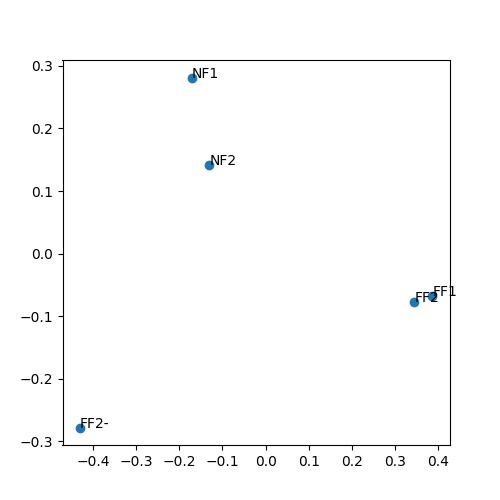

In [54]:
import PcmPy as pcm
labels = ['NF1','FF1','NF2','FF2','FF2-']

tp = 15
rdm_v = rdm[1][tp,:]
rdm_m = squareform(rdm_v)
n_cond = rdm_m.shape[0]

H = np.eye(n_cond) - np.ones((n_cond,n_cond))/n_cond
G = -0.5*H@rdm_m@H

# np.sum(pcm.G_to_dist(G)-rdm_m) # sanity check
W,Glam = pcm.classical_mds(G)

fig,ax = plt.subplots(1,1,figsize=(5,5))


plt.scatter(W[:,0],W[:,1])
for i, label in enumerate(labels):
    plt.annotate(label, (W[i,0],W[i,1]))
plt.show()